In [1]:
import re
import requests
import datetime as dt
import pandas as pd
import plotly.express as px

## Inputs

In [2]:
YEARS = 10
BASE_URL = f"https://api.nasdaq.com/api"

TOTAL_DAYS = 365 * YEARS + 1
TRADING_DAYS = 252 * YEARS

START_DAY = (dt.datetime.now() - dt.timedelta(days=TOTAL_DAYS)).strftime("%Y-%m-%d")

In [3]:
ticker = "aapl"

## Utils

In [4]:
def get_response(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.2 Safari/605.1.15" 
    }

    session = requests.Session()
    response = session.get(url=url, headers=headers)

    return response.json()

In [5]:
def get_dataframe(data):
    try:
        cols = data["headers"]
        use_cols = list(cols.keys())

        rows = data["rows"]
    except KeyError:
        rows = data["nocp"]["nocpTable"]
    except AttributeError:
         return "There are no symbols that match your search criteria."

    df = pd.DataFrame(data=rows, columns=use_cols)
    df.columns = list(cols.values())
    df.set_index(df.columns[0], inplace=True)

    return df

In [6]:
def snakecase_to_camelcase(s):
    return re.sub(r'_([a-z])', lambda x: x.group(1).upper(), s)

In [7]:
def string_to_float(s):
    return float(re.sub(r"[\$\,]+", "", s))

## Screener

In [8]:
# There are all possible filters for the Stock Screener:
# Limit: limit = 0+ (0 = all data, 1+ = rows)
# Exchange: exchange = ["nasdaq", "nyse", "amex"]
# Market Cap: marketcap = ["mega", "large", "mid", "small", "micro", "nano"]
# Analyst Rating: recommendation = ["strong_buy", "hold", "buy", "sell", "strong_sell"]
# Sector: sector = ["technology", "telecommunications", "health_care", "finance", "real_estate", "consumer_discretionary", "consumer_staples", "industrials", "basic_materials", "energy", "utilities"]
# Region: region = ["africa", "asia", "australia_and_south_pacific", "caribbean", "europe", "middle_east", "north_america", "south_america"]
# Country: country = ["argentina", "armenia", "australia", "austria", "belgium", "bermuda", "brazil", "canada", "cayman_islands", "chile", "colombia", "costa_rica", "curacao",
#                     "cyprus", "denmark", "finland", "france", "germany", "greece", "guernsey", "hong_kong", "india", "indonesia", "ireland", "isle_of_man", "israel", "italy",
#                     "japan", "jersey","luxembourg", "macau", "mexico", "monaco", "netherlands", "norway", "panama", "peru", "philippines", "puerto_rico", "russia", "singapore",
#                     "south_africa", "south_korea","spain", "sweden", "switzerland", "taiwan", "turkey", "united_kingdom", "united_states", "usa"]

# URL Example: https://api.nasdaq.com/api/screener/stocks?limit=0&exchange=nasdaq&marketcap=mega|large|mid&recommendation=strong_buy&sector=technology&region=north_america&country=united_states

In [9]:
def screener(limit=0, **kwargs):
    parameters = {
        "exchange": ["nasdaq", "nyse", "amex"],
        "marketcap": ["mega", "large", "mid", "small", "micro", "nano"],
        "recommendation": ["strong_buy", "hold", "buy", "sell", "strong_sell"],
        "sector": ["technology", "telecommunications", "health_care", "finance", "real_estate", "consumer_discretionary", "consumer_staples", "industrials", "basic_materials", "energy", "utilities"],
        "region": ["africa", "asia", "australia_and_south_pacific", "caribbean", "europe", "middle_east", "north_america", "south_america"],
        "country": ["argentina", "armenia", "australia", "austria", "belgium", "bermuda", "brazil", "canada", "cayman_islands", "chile", "colombia", "costa_rica", "curacao",
                    "cyprus", "denmark", "finland", "france", "germany", "greece", "guernsey", "hong_kong", "india", "indonesia", "ireland", "isle_of_man", "israel", "italy",
                    "japan", "jersey","luxembourg", "macau", "mexico", "monaco", "netherlands", "norway", "panama", "peru", "philippines", "puerto_rico", "russia", "singapore",
                    "south_africa", "south_korea","spain", "sweden", "switzerland", "taiwan", "turkey", "united_kingdom", "united_states", "usa"]
    }

    url = f"{BASE_URL}/screener/stocks?limit={limit}"

    for i, v in kwargs.items():
        if isinstance(v, list):
            v = "|".join(v) if all(item in parameters[i] for item in v) else ""
        url += f"&{i}={v}"

    response = get_response(url)
    data = response["data"]["table"]

    df = get_dataframe(data)

    return df

In [10]:
screener(exchange="nasdaq", marketcap=["mega", "large", "mid"], sector=["technology", "health_care", "finance"])

,Name,Last Sale,Net Change,% Change,Market Cap
Symbol,,,,,
AAPL,Apple Inc. Common Stock,$134.76,1.35,1.012%,"2,336,379,938,400"
MSFT,Microsoft Corporation Common Stock,$239.23,0.72,0.302%,"1,783,333,610,239"
GOOG,Alphabet Inc. Class C Capital Stock,$92.80,0.89,0.968%,"1,201,110,400,000"
GOOGL,Alphabet Inc. Class A Common Stock,$92.12,0.99,1.086%,"1,192,309,160,000"
NVDA,NVIDIA Corporation Common Stock,$168.99,3.88,2.35%,"415,715,400,000"
...,...,...,...,...,...
SBCF,Seacoast Banking Corporation of Florida Common...,$32.76,-0.09,-0.274%,"2,013,964,505"
RPD,"Rapid7, Inc. Common Stock",$33.92,-0.26,-0.761%,"2,009,282,406"
VCTR,"Victory Capital Holdings, Inc. Class A Common ...",$29.30,-0.19,-0.644%,"2,006,432,356"


## Key Data

In [11]:
def summary(ticker):
    url = f"{BASE_URL}/quote/{ticker}/summary?assetclass=stocks"

    response = get_response(url)
    data = list(response["data"]["summaryData"].values())

    lbls = [i["label"] for i in data]
    vals = [j["value"] for j in data]

    df = pd.DataFrame(data=vals, index=lbls, columns=[ticker])

    return df

In [12]:
summary(ticker)

,aapl
Exchange,NASDAQ-GS
Sector,Technology
Industry,Computer Manufacturing
1 Year Target,$177.03
Today's High/Low,N/A
Share Volume,"34,555"
Average Volume,"80,874,456"
Previous Close,$134.76
52 Week High/Low,$179.61/$124.17
Market Cap,"2,328,578,135,400"


## Dividend History

The Dividend History page provides a single page to review all of the aggregated Dividend payment information.

In [13]:
def dividends(ticker):
    url = f"{BASE_URL}/quote/{ticker}/dividends?assetclass=stocks"

    response = get_response(url)
    data = response["data"]["dividends"]

    df = get_dataframe(data)

    return df

In [14]:
dividends(ticker)

,TYPE,CASH AMOUNT,DECLARATION DATE,RECORD DATE,PAYMENT DATE
Ex/EFF DATE,,,,,
11/04/2022,CASH,$0.23,10/27/2022,11/07/2022,11/10/2022
08/05/2022,CASH,$0.23,07/28/2022,08/08/2022,08/11/2022
05/06/2022,CASH,$0.23,04/28/2022,05/09/2022,05/12/2022
02/04/2022,CASH,$0.22,01/27/2022,02/07/2022,02/10/2022
11/05/2021,CASH,$0.22,10/28/2021,11/08/2021,11/11/2021
...,...,...,...,...,...
11/17/1989,CASH,$0.11,N/A,11/17/1989,N/A
08/21/1989,CASH,$0.10,N/A,08/21/1989,N/A
05/22/1989,CASH,$0.10,N/A,05/22/1989,N/A


## Historical Quotes

Get up to 10 years of daily historical stock prices & volumes. The **Close/Last** is the “adjust consolidated close price”.

In [15]:
def quotes_history(ticker, from_date=START_DAY, limit=TRADING_DAYS):
    url = f"{BASE_URL}/quote/{ticker}/historical?assetclass=stocks&fromdate={from_date}&limit={limit}"

    response = get_response(url)
    data = response["data"]["tradesTable"]

    df = get_dataframe(data)

    return df

In [16]:
quotes_history(ticker)

,Close/Last,Volume,Open,High,Low
Date,,,,,
01/13/2023,$134.76,"57,809,720",$132.03,$134.92,$131.66
01/12/2023,$133.41,"71,379,650",$133.88,$134.26,$131.44
01/11/2023,$133.49,"69,458,950",$131.25,$133.51,$130.46
01/10/2023,$130.73,"63,896,160",$130.26,$131.2636,$128.12
01/09/2023,$130.15,"70,790,810",$130.465,$133.41,$129.89
...,...,...,...,...,...
01/25/2013,$15.71,"1,206,468,837",$16.1318,$16.2939,$15.5357
01/24/2013,$16.0893,"1,457,835,377",$16.4286,$16.6332,$16.0804
01/23/2013,$18.3573,"764,359,934",$18.1718,$18.3925,$18.0275


In [17]:
def chart(data):
    if data.empty:
        print("No data to display.")
    else:
        data = data.applymap(lambda x: string_to_float(x))
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        chart = px.area(x=data.index, y=data["Close/Last"])

        axes_layout = {
                        "gridcolor": "rgb(240, 240, 240)",
                        "showspikes": True,
                        "spikecolor": "rgb(120, 120, 240)",
                        "spikemode": "across",
                        "spikesnap": "cursor",
                        "spikedash": "dash",
                        "spikethickness": 0.5
                        }

        chart.update_xaxes(
            axes_layout,
            title_text="Date",
            rangeselector={
                "buttons": [
                    {"count": 1, "label": "1M", "step": "month", "stepmode": "backward"},
                    {"count": 3, "label": "3M", "step": "month", "stepmode": "backward"},
                    {"count": 6, "label": "6M", "step": "month", "stepmode": "backward"},
                    {"count": 1, "label": "YTD", "step": "year", "stepmode": "todate"},
                    {"count": 1, "label": "1Y", "step": "year", "stepmode": "backward"},
                    {"count": 3, "label": "3Y", "step": "year", "stepmode": "backward"},
                    {"count": 5, "label": "5Y", "step": "year", "stepmode": "backward"},
                    {"label": "MAX", "step": "all"}]})

        chart.update_yaxes(axes_layout, title_text="Price", tickprefix="$")

        chart.update_layout(
            plot_bgcolor="rgb(250, 250, 250)",
            hovermode="x",
            spikedistance=-1,
            hoverdistance=-1,
            showlegend=False,
            title={
                "text": f"{ticker.upper()} Stock Price History",
                "y": 0.97,
                "x": 0.5,
                "xanchor": "center",
                "yanchor": "top"})

        chart.update_traces(hovertemplate="Date: %{x}<br>Price: %{y}")

        chart.show();

In [18]:
chart(quotes_history(ticker))

## Historical NOCP

Nasdaq Official Closing Price (NOCP) is a process for identifying the Nasdaq market-specific closing price for Nasdaq-listed issues.

In [19]:
def nocp_history(ticker, timeframe=None):
    timeframe = timeframe if timeframe in ["d5", "m1", "m3", "m6"] else "y1"

    url = f"{BASE_URL}/company/{ticker}/historical-nocp?timeframe={timeframe}"

    response = get_response(url)
    data = response["data"]

    df = get_dataframe(data)

    return df

In [20]:
nocp_history(ticker, timeframe="m1")

,Nasdaq Closing Price
Trade Date,
01/13/2023,$134.76
01/12/2023,$133.41
01/11/2023,$133.49
01/10/2023,$130.73
01/09/2023,$130.15
01/06/2023,$129.62
01/05/2023,$125.02
01/04/2023,$126.36
01/03/2023,$125.07


## Financials

In [21]:
def financials(ticker, table="income_statement", frequency=None):
    freq = 2 if frequency == "quarterly" else 1

    url = f"{BASE_URL}/company/{ticker}/financials?frequency={freq}"

    response = get_response(url)

    if table == "balance_sheet":
        data = response["data"]["balanceSheetTable"]
    elif table == "cash_flow":
        data = response["data"]["cashFlowTable"]
    elif table == "financial_ratios":
        data = response["data"]["financialRatiosTable"]
    else:
        data = response["data"]["incomeStatementTable"]

    df = get_dataframe(data)

    return df

In [22]:
financials(ticker, table="cash_flow", frequency="quarterly")

,9/24/2022,6/25/2022,3/26/2022,12/25/2021
Quarterly Ending:,,,,
Net Income,"$20,721,000","$19,442,000","$25,010,000","$34,630,000"
Cash Flows-Operating Activities,,,,
Depreciation,"$2,865,000","$2,805,000","$2,737,000","$2,697,000"
Net Income Adjustments,"$589,000","$3,870,000","$2,471,000","$3,114,000"
Changes in Operating Activities,,,,
Accounts Receivable,"-$18,693,000","$3,165,000","$19,931,000","-$13,746,000"
Changes in Inventories,"$435,000","-$16,000","$384,000","$681,000"
Other Operating Activities,"-$3,210,000","$253,000","$1,379,000","-$4,921,000"
Liabilities,"$21,420,000","-$6,627,000","-$23,746,000","$24,511,000"


## Earnings

### Earnings Per Share

In [23]:
def eps(ticker):
    url = f"{BASE_URL}/quote/{ticker}/eps"

    response = get_response(url)
    data = response["data"]["earningsPerShare"]

    lbls = [i["period"] for i in data]
    vals = [(j["consensus"], j["earnings"]) for j in data]

    df = pd.DataFrame(data=vals, index=lbls, columns=["Estimated EPS", "Reported EPS"])

    return df

In [24]:
data = eps(ticker)
data

,Estimated EPS,Reported EPS
Dec 2021,1.89,2.10
Mar 2022,1.43,1.52
Jun 2022,1.14,1.20
Sep 2022,1.26,1.29
Dec 2022,1.93,0.00
Mar 2023,1.51,0.00
Jun 2023,1.28,0.00
Sep 2023,1.44,0.00


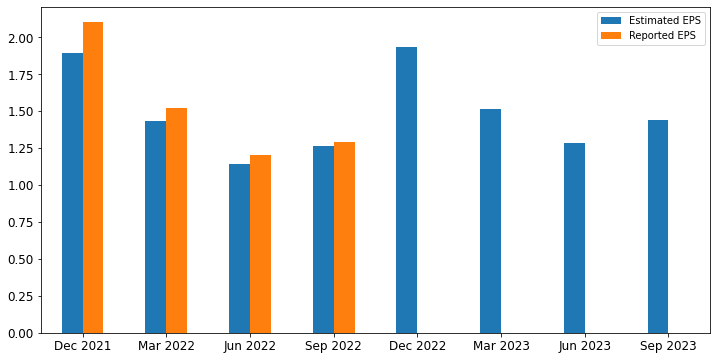

In [25]:
data.plot(kind="bar", figsize=(12, 6), fontsize=12, rot=0);

### Earnings Forecast (Yearly/Quarterly)

In [26]:
def earnings_forecast(ticker, frequency=None):
    url = f"{BASE_URL}/analyst/{ticker}/earnings-forecast"

    response = get_response(url)

    data = response["data"]["quarterlyForecast"] if frequency == "quarterly" else response["data"]["yearlyForecast"]

    df = get_dataframe(data)

    return df

In [27]:
earnings_forecast(ticker, frequency="quarterly")

,Consensus EPS* Forecast,High EPS* Forecast,Low EPS* Forecast,Number of Estimates,Over the Last 4 Weeks Number of Revisions - Up,Over the Last 4 Weeks Number of Revisions - Down
Fiscal Quarter End,,,,,,
Dec 2022,1.93,2.08,1.82,12,0,2
Mar 2023,1.51,1.69,1.34,10,2,0
Jun 2023,1.28,1.35,1.18,10,1,0
Sep 2023,1.44,1.49,1.36,10,0,0
Dec 2023,2.19,2.32,1.77,8,0,0


## Price/Earnings & PEG Ratios

### Price/Earnings Ratio

Price/Earnings Ratio is a widely used stock evaluation measure. For a security, the Price/Earnings Ratio is given by dividing the Last Sale Price by the Average EPS (Earnings Per Share) Estimate for the specified fiscal time period.

In [28]:
def pe_ratio(ticker):
    url = f"{BASE_URL}/analyst/{ticker}/peg-ratio"

    response = get_response(url)
    data = response["data"]["per"]

    lbls = [i["x"] for i in data["peRatioChart"]]
    vals = [j["y"] for j in data["peRatioChart"]]

    df = pd.DataFrame(data=vals, index=lbls, columns=[data["label"]])

    return df

In [29]:
pe_ratio(ticker)

,Price/Earnings Ratio
2022 Actual,22.06
2023 Estimates,21.77
2024 Estimates,20.02
2025 Estimates,18.24


### Forecast P/E Growth Rates

In [30]:
def pe_growth(ticker):
    url = f"{BASE_URL}/analyst/{ticker}/peg-ratio"

    response = get_response(url)
    data = response["data"]["gr"]

    lbls = [f"{i['z']} {i['x']}" for i in data["peGrowthChart"]]
    vals = [j["y"] for j in data["peGrowthChart"]]

    df = pd.DataFrame(data=vals, index=lbls, columns=[data["title"]])

    return df

In [31]:
pe_growth(ticker)

,Forecast P/E Growth Rates
Growth 2023,1.32
Growth 2024,8.78
P/E Ratios 2023,21.77
P/E Ratios 2024,20.02


### PEG Ratio

Investors are always looking for companies with good growth prospects selling at attractive prices. One popular statistic used to identify such stocks is the PEG ratio - which is simply the Price Earnings ratio divided by the growth rate. In this case we use the forecasted growth rate (based on the consensus of professional analysts) and forecasted earnings over the next 12 months. In theory, the lower the PEG ratio the better - implying that you are paying less for future earnings growth.

In [32]:
def peg_ratio(ticker):
    url = f"{BASE_URL}/analyst/{ticker}/peg-ratio"

    response = get_response(url)
    data = response["data"]["pegr"]

    lbls = data["label"]
    vals = data["pegValue"]

    df = pd.DataFrame(data=vals, index=[lbls], columns=["PEG Ratio"])

    return df

In [33]:
peg_ratio(ticker)

,PEG Ratio
Forecast 12 Month Forward PEG Ratio,1.74


## Short Interest

Short interest and days to cover can be used to indicate market sentiment and gauge the stock market in an investor’s analysis. Please note: If days to cover is between 0 and 1, it is rounded up to 1.

In [34]:
def short_interest(ticker):
    url = f"{BASE_URL}/quote/{ticker}/short-interest?assetClass=stocks"

    response = get_response(url)
    data = response["data"]["shortInterestTable"]

    df = get_dataframe(data)

    return df

In [35]:
short_interest(ticker)

,SHORT INTEREST,AVG. DAILY SHARE VOLUME,DAYS TO COVER
SETTLEMENT DATE,,,
12/30/2022,"124,024,570","85,155,771",1.456444
12/15/2022,"121,757,434","74,824,553",1.627239
11/30/2022,"125,719,918","68,776,114",1.827959
11/15/2022,"114,431,895","94,210,713",1.214638
10/31/2022,"103,178,670","91,546,622",1.127061
10/14/2022,"108,664,761","85,960,932",1.264118
09/30/2022,"103,251,184","110,439,712",1.000000
09/15/2022,"116,076,947","87,048,374",1.333476
08/31/2022,"113,066,596","67,830,391",1.666902


## Institutional Holdings

Institutional Holdings information can be used to gauge the volatility and value on the company’s stock.

In [36]:
def institutional_holdings(ticker, limit=5000, **kwargs):
    parameters = {
        "type_": ["total", "new", "increased", "decreased", "activity", "soldout"],
        "sortColumn": ["ownerName", "date", "sharesHeld", "sharesChange", "sharesChangePCT", "marketValue"],
        "sortOrder": ["asc", "desc"]
    }

    url = f"{BASE_URL}/company/{ticker}/institutional-holdings?limit={limit}&tableonly=true"

    for i, v in kwargs.items():
        i = snakecase_to_camelcase(i.strip('_'))
        url += f"&{i}={v}"

    response = get_response(url)
    data = response["data"]["holdingsTransactions"]["table"]

    df = get_dataframe(data)

    return df

In [37]:
institutional_holdings(ticker, type_="total", sort_column="marketValue", sort_order="desc")

,DATE,SHARES HELD,CHANGE (SHARES),CHANGE (%),"VALUE (IN 1,000S)"
OWNER NAME,,,,,
VANGUARD GROUP INC,09/30/2022,"1,272,378,901","-4,940,153",-0.387%,"$171,465,781"
BLACKROCK INC.,09/30/2022,"1,020,245,185","-8,443,132",-0.821%,"$137,488,241"
BERKSHIRE HATHAWAY INC,09/30/2022,"894,802,319",0,0%,"$120,583,561"
STATE STREET CORP,09/30/2022,"591,543,874","-6,634,650",-1.109%,"$79,716,452"
FMR LLC,09/30/2022,"350,900,116","6,582,142",1.912%,"$47,287,300"
...,...,...,...,...,...
"VIRTUS FUND ADVISERS, LLC",09/30/2022,0,"-3,152,112",Sold Out,
"VOLORIDGE INVESTMENT MANAGEMENT, LLC",09/30/2022,0,"-1,356,261",Sold Out,
WARATAH CAPITAL ADVISORS LTD.,09/30/2022,0,"-31,149",Sold Out,


## Insider Activity

In [38]:
def insider_activity(ticker, limit=5000, **kwargs):
    parameters = {
        "type_": ["all", "buys", "sells"],
        "sortColumn": ["insider", "relation", "lastDate", "transactionType", "ownType", "sharesTraded", "lastPrice", "sharesHeld"],
        "sortOrder": ["asc", "desc"]
    }

    url = f"{BASE_URL}/company/{ticker}/insider-trades?limit={limit}"

    for i, v in kwargs.items():
        i = snakecase_to_camelcase(i.strip('_'))
        url += f"&{i}={v}"

    response = get_response(url)
    data = response["data"]["transactionTable"]["table"]

    df = get_dataframe(data)

    return df

In [39]:
insider_activity(ticker, type_="all", sort_column="lastDate", sort_order="desc")

,RELATION,LAST DATE,TRANSACTION,OWNER TYPE,SHARES TRADED,PRICE,SHARES HELD
INSIDER,,,,,,,
KONDO CHRIS,Officer,11/22/2022,Sell,Direct,"20,200",$148.72,"31,505"
MAESTRI LUCA,Officer,10/28/2022,Automatic Sell,Direct,"176,299",$154.70,"110,673"
O'BRIEN DEIRDRE,Officer,10/17/2022,Automatic Sell,Direct,"8,053",$142.45,"136,290"
KONDO CHRIS,Officer,10/15/2022,Disposition (Non Open Market),Direct,"6,399",$138.38,"51,705"
KONDO CHRIS,Officer,10/15/2022,Option Execute,Direct,"13,136",,"58,104"
...,...,...,...,...,...,...,...
JUNG ANDREA,Director,02/01/2021,Option Execute,Indirect,"3,416",,"137,608"
LEVINSON ARTHUR D,Director,02/01/2021,Option Execute,Direct,"3,416",,"4,536,140"
LOZANO MONICA C,Director,02/01/2021,Option Execute,Direct,281,,"1,568"


## Revenue EPS

Revenue and Earnings Per Share (EPS) are the heart of the fundamental analysis of a company's worth. The Revenue and EPS Summary provides the Revenue, EPS and Dividends of a company by year and quarter for the past three years, on a single page.

In [40]:
def revenue_eps(ticker):
    limit = 1
    df = pd.DataFrame()

    while True:
        url = f"{BASE_URL}/company/{ticker}/revenue?limit={limit}"

        response = get_response(url)
        data = response["data"]["revenueTable"]

        if not data:
            break

        tmp_df = get_dataframe(data)
        df = pd.concat([df, tmp_df], axis=1)
        limit += 1

    return df

In [41]:
revenue_eps(ticker)

,2022 (FISCAL YEAR),2021 (FISCAL YEAR),2020 (FISCAL YEAR),2019 (FISCAL YEAR),2018 (FISCAL YEAR),2017 (FISCAL YEAR),2016 (FISCAL YEAR),2015 (FISCAL YEAR),2014 (FISCAL YEAR),2013 (FISCAL YEAR),...,2005 (FISCAL YEAR),2004 (FISCAL YEAR),2003 (FISCAL YEAR),2002 (FISCAL YEAR),2001 (FISCAL YEAR),2000 (FISCAL YEAR),1999 (FISCAL YEAR),1998 (FISCAL YEAR),1997 (FISCAL YEAR),1996 (FISCAL YEAR)
FISCAL QUARTER:,,,,,,,,,,,,,,,,,,,,,
DECEMBER,,,,,,,,,,,...,,,,,,,,,,
REVENUE,"$123,945(m)","$111,439(m)","$91,819(m)","$84,310(m)","$88,293(m)","$78,351(m)","$75,872(m)","$74,599(m)","$57,594(m)","$54,512(m)",...,"$3,490(m)","$2,006(m)","$1,472(m)","$1,375(m)","$1,007(m)","$2,343(m)","$1,710(m)","$1,578(m)",,
EPS,$2.10 (12/25/2021),$1.68 (12/26/2020),$1.25 (12/28/2019),$1.04 (12/29/2018),$0.97 (12/30/2017),$0.84 (12/31/2016),$0.82 (12/26/2015),$0.76 (12/27/2014),$0.52 (12/28/2013),$0.49 (12/29/2012),...,$0.01 (12/25/2004),$0.00 (12/27/2003),($0.00) (12/28/2002),$0.00 (12/29/2001),($0.01) (12/30/2000),$0.01 (01/01/2000),$0.01 (12/26/1998),N/A,,
DIVIDENDS,$0.22,$0.20,$0.19,$0.18,$0.16,$0.14,$0.13,$0.12,$0.11,$0.09,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,,
MARCH,,,,,,,,,,,...,,,,,,,,,,
REVENUE,"$97,278(m)","$89,584(m)","$58,313(m)","$58,015(m)","$61,137(m)","$52,896(m)","$50,557(m)","$58,010(m)","$45,646(m)","$43,603(m)",...,"$3,243(m)","$1,909(m)","$1,475(m)","$1,495(m)","$1,431(m)","$1,945(m)","$1,530(m)","$1,405(m)",,
EPS,$1.52 (03/26/2022),$1.40 (03/27/2021),$0.64 (03/28/2020),$0.62 (03/30/2019),$0.68 (03/31/2018),$0.52 (04/01/2017),$0.48 (03/26/2016),$0.58 (03/28/2015),$0.42 (03/29/2014),$0.36 (03/30/2013),...,$0.01 (03/26/2005),$0.00 (03/27/2004),$0.00 (03/29/2003),$0.00 (03/30/2002),$0.00 (03/31/2001),$0.01 (04/01/2000),$0.01 (03/27/1999),N/A,,
DIVIDENDS,$0.23,$0.22,$0.20,$0.19,$0.18,$0.16,$0.14,$0.13,N/A,$0.11,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,,
JUNE,,,,,,,,,,,...,,,,,,,,,,
